In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nmf_methods.nmf_son.new import new as nmf_son_new
from nmf_methods.nmf_son.utils import save_results, load_results

np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def create_toy_ex(n):
    W = np.random.rand(2, 3)
    H = np.ones((3, n))
    thres = 0.88
    id = np.argwhere(np.sum(H >= thres, axis=0))
    while id.any():
        id = np.argwhere(np.sum(H >= thres, axis=0))
        H[:, id.flatten()] = np.random.dirichlet((0.33, 0.33, 0.33), len(id)).T

    M = W @ H
    return M, W, H

def plot_mats(ax, M, W, W_true):
    symbols = ['o', 'x', 'v', 's', '.']
    for i in range(len(symbols)):
        ax.plot(W[0, i], W[1, i],f'r{symbols[i]}', markersize=5, linewidth=2)
    ax.plot(M[0, :], M[1, :],'k.')

    for j in range(W_true.shape[1]):
        ax.plot(W_true[0, j], W_true[1, j],'bx', markersize=5, linewidth=2)

In [3]:
toy_filepath = '../../experimental/datasets/toy_n30.npz'
M, W_true, H_true = create_toy_ex(30)
with open(toy_filepath, 'wb') as fout:
    np.savez_compressed(fout, M=M, W=W_true, H=H_true)

data = np.load(toy_filepath)
M = data['M']
W_true = data['W']
H = data['H']

In [4]:
EARLY_STOP = True
VERBOSE = False
SCALE_REG = True

m, n = M.shape
r = 5
_lam = 1
max_iters = 10000

ini_filepath = f'../../experimental/saved_models/toy/r{r}_ini.npz'
save_filepath = '../../experimental/saved_models/toy/r{}_l{}_mit{}.npz'

In [5]:
ini_W = np.random.rand(m, r)
ini_H = np.random.rand(r, n)
with open(ini_filepath, 'wb') as fp:
    np.savez_compressed(fp, ini_W=ini_W, ini_H=ini_H)

data = np.load(ini_filepath)
ini_W = data['ini_W']
ini_H = data['ini_H']

In [6]:
W, H, fscores, gscores, lvals = nmf_son_new(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=max_iters, early_stop=EARLY_STOP, verbose=VERBOSE, scale_reg=SCALE_REG)
save_results(save_filepath.format(r, _lam, max_iters), W, H, fscores, gscores, lvals)

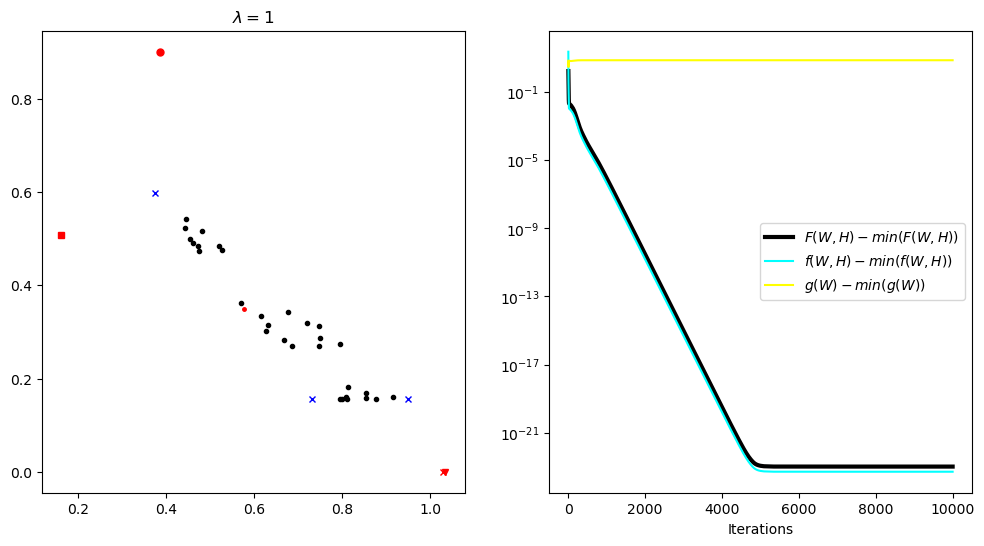

In [7]:
W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title(f'$\lambda = {_lam}$')
plot_mats(axs[0], M, W, W_true)
total_score = fscores + lvals * gscores
axs[1].set_yscale('log')
axs[1].plot(total_score, color='black', linewidth=3, label='$F(W, H) - min(F(W, H))$')
axs[1].plot(fscores, color='cyan', linewidth=1.5, label='$f(W, H) - min(f(W, H))$')
axs[1].plot(gscores, color='yellow', linewidth=1.5, label='$g(W) - min(g(W))$')
axs[1].set_xlabel('Iterations')
axs[1].legend()